In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

## Loading the data

In [2]:
def get_data_from_gcp(nrows=10000, optimize=False, **kwargs):
    """method to get the training data (or a portion of it) from GCP"""
    true_path = 'https://storage.googleapis.com/wagon-data-615-seguy/data/True.csv'
    fake_path = 'https://storage.googleapis.com/wagon-data-615-seguy/data/Fake.csv'
    true_df = pd.read_csv(true_path, nrows=nrows)
    fake_df = pd.read_csv(fake_path, nrows=nrows)
    return true_df, fake_df

In [3]:
true, fake = get_data_from_gcp(nrows=None)

print('-'*80)
print(f"true shape: {true.shape}")
print(f"fake shape: {fake.shape}")
print('-'*80)

--------------------------------------------------------------------------------
true shape: (21417, 4)
fake shape: (23481, 4)
--------------------------------------------------------------------------------


## Duplicates

In [4]:
def count_duplicate(df):
    return df.duplicated().sum()

In [5]:
print('-'*80)
print(f"true duplicates: {count_duplicate(true)}")
print(f"fake duplicates: {count_duplicate(fake)}")
print('-'*80)

--------------------------------------------------------------------------------
true duplicates: 206
fake duplicates: 3
--------------------------------------------------------------------------------


In [6]:
true.drop_duplicates(inplace=True)
fake.drop_duplicates(inplace=True)

print('-'*80)
print(f"true shape (wo duplicates): {true.shape}")
print(f"fake shape (wo duplicates): {fake.shape}")
print('-'*80)

--------------------------------------------------------------------------------
true shape (wo duplicates): (21211, 4)
fake shape (wo duplicates): (23478, 4)
--------------------------------------------------------------------------------


In [7]:
true['category'] = 0
fake['category'] = 1

data = pd.concat([true, fake]).reset_index()

print('-'*80)
print(f"data shape: {data.shape}")
print('-'*80)
print(f"ratio #true: {len(data[data['category']==0])/len(data)*100:.2f}%")
print(f"ratio #fake: {len(data[data['category']==1])/len(data)*100:.2f}%")
print('-'*80)

--------------------------------------------------------------------------------
data shape: (44689, 6)
--------------------------------------------------------------------------------
ratio #true: 47.46%
ratio #fake: 52.54%
--------------------------------------------------------------------------------


## Missing values

In [8]:
def get_missing(df):
    missing_values = df.isnull().sum().sort_values(ascending = False)
    ratio = missing_values/len(data)*100
    return pd.DataFrame({'missing_values': missing_values, 'ratio': round(ratio)}).head(10)

In [9]:
get_missing(data)

,missing_values,ratio
category,0,0.0
date,0,0.0
subject,0,0.0
text,0,0.0
title,0,0.0
index,0,0.0


## Preprocessing

In [10]:
import string
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize

# Required only for Colab
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def clean(text):
    """
    Provided by Le Wagon - Machine Learning - NLP
    Preprocessing articles - punctuation / lowercased / tokenize / stop_words / lemmatize
    """
    for punctuation in string.punctuation:
        text = text.replace(punctuation, ' ') # Remove Punctuation
    lowercased = text.lower() # Lower Case
    tokenized = word_tokenize(lowercased) # Tokenize
    words_only = [word for word in tokenized if word.isalpha()] # Remove numbers
    stop_words = set(stopwords.words('english')) # Make stopword list
    without_stopwords = [word for word in words_only if not word in stop_words] # Remove Stop Words
    lemma = WordNetLemmatizer() # Initiate Lemmatizer
    lemmatized = [lemma.lemmatize(word) for word in without_stopwords] # Lemmatize
    return lemmatized

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [11]:
data['clean_text'] = data['text'].apply(clean)
data['clean_title'] = data['title'].apply(clean)

## Training

In [12]:
X_text = data['clean_text'].copy()
X_title = data['clean_title'].copy()
y = data['category'].copy()

print('-'*80)
print(f"X_text shape: {X_text.shape}")
print(f"X_title shape: {X_title.shape}")
print(f"y shape: {y.shape}")
print('-'*80)

--------------------------------------------------------------------------------
X_text shape: (44689,)
X_title shape: (44689,)
y shape: (44689,)
--------------------------------------------------------------------------------


In [80]:
from sklearn.model_selection import train_test_split

X_text_train, X_text_test, y_train, y_test = train_test_split(X_text, y, test_size=0.3, random_state=42)
X_title_train, X_title_test, y_train, y_test = train_test_split(X_title, y, test_size=0.3, random_state=42)


print('-'*80)
print(f"X_text_train shape: {X_text_train.shape}")
print(f"X_title_train shape: {X_title_train.shape}")
print(f"y_train shape: {y_train.shape}")
print('-'*80)
print(f"X_text_test shape: {X_text_test.shape}")
print(f"X_title_test shape: {X_title_test.shape}")
print(f"y_test shape: {y_test.shape}")
print('-'*80)

--------------------------------------------------------------------------------
X_text_train shape: (31282,)
X_title_train shape: (31282,)
y_train shape: (31282,)
--------------------------------------------------------------------------------
X_text_test shape: (13407,)
X_title_test shape: (13407,)
y_test shape: (13407,)
--------------------------------------------------------------------------------


In [84]:
X_text_train

28999    [one, recognizable, actor, generation, starred...
12753    [houston, reuters, venezuela, former, oil, cza...
34585    [inserted, thought, tweet, throughout, article...
19345    [madrid, reuters, spanish, prime, minister, ma...
25075    [racist, ku, klux, klan, pleased, donald, trum...
                               ...                        
6265     [berlin, reuters, german, finance, minister, w...
11284    [puerto, ordaz, venezuela, reuters, venezuelan...
38158    [u, great, enemy, mankind, raved, ernesto, che...
860      [new, york, reuters, u, money, manager, reinsu...
15795    [sydney, reuters, hundred, asylum, seeker, ref...
Name: clean_text, Length: 31282, dtype: object

In [79]:
from tensorflow.keras.preprocessing.text import Tokenizer

# This initializes a Keras utilities that does all the tokenization for you
text_tokenizer = Tokenizer()
title_tokenizer = Tokenizer()

# The tokenization learns a dictionnary that maps a token (integer) to each word
# It can be done only on the train set - we are not supposed to know the test set !
# This tokenization also lower your words, apply some filters, and so on - you can check the doc if you want
text_tokenizer.fit_on_texts(X_text_train)
title_tokenizer.fit_on_texts(X_title_train)

    
# We apply the tokenization to the train and test set
X_text_train_token = text_tokenizer.texts_to_sequences(X_text_train)
X_title_train_token = title_tokenizer.texts_to_sequences(X_title_train)

X_text_test_token = text_tokenizer.texts_to_sequences(X_text_test)
X_title_test_token = title_tokenizer.texts_to_sequences(X_title_test)

print('-'*80)
print(f"X_text_train_token shape: {len(X_text_train_token)}")
print(f"X_title_train_token shape: {len(X_title_train_token)}")
print(f"X_text_test_token shape: {len(X_text_test_token)}")
print(f"X_title_test_token shape: {len(X_title_test_token)}")
print('-'*80)

--------------------------------------------------------------------------------
X_text_train_token shape: 31282
X_title_train_token shape: 31282
X_text_test_token shape: 13407
X_title_test_token shape: 13407
--------------------------------------------------------------------------------


In [72]:
X_text_train_token[0]

[10,
 14644,
 1513,
 1868,
 12964,
 11352,
 2308,
 285,
 171,
 5059,
 256,
 339,
 10264,
 11077,
 189,
 461,
 1513,
 1447,
 4489,
 2121,
 256,
 339,
 448,
 30845,
 11077,
 201,
 777,
 3087,
 114,
 9,
 1046,
 3839,
 543,
 143,
 2,
 30846,
 170,
 696,
 94,
 14953,
 8,
 3083,
 368,
 1590,
 343,
 663,
 96,
 974,
 3020,
 3557,
 456,
 453,
 5608,
 543,
 143,
 310,
 1601,
 24,
 4443,
 311,
 1316,
 638,
 9512,
 95,
 110,
 8162,
 554,
 296,
 43729,
 95,
 73,
 61,
 172,
 94,
 850,
 330,
 12965,
 330,
 1533,
 931,
 416,
 2364,
 931,
 157,
 209,
 1317,
 56763,
 339,
 226,
 4018,
 5812,
 1026,
 4489,
 2121,
 84,
 807,
 20,
 287,
 1181,
 8328,
 273,
 1977,
 2102,
 4071,
 2545,
 9430,
 1569,
 4189,
 4516,
 711,
 14096,
 1490,
 701,
 1329,
 3,
 3246,
 2471,
 968,
 8041,
 1346,
 14954,
 1513,
 620,
 968,
 8041,
 2425,
 461,
 1513,
 56,
 204,
 608,
 5,
 1008,
 1581,
 1803,
 48,
 9,
 1347,
 3697,
 543,
 143,
 13187,
 444,
 14097,
 330,
 147,
 1533,
 12379,
 2767,
 283,
 5473,
 399,
 451,
 543,
 143,
 10,

In [15]:
text_vocab_size = len(text_tokenizer.word_index)
title_vocab_size = len(title_tokenizer.word_index)

print('-'*80)
print(f"text vocab_size: {text_vocab_size}")
print(f"title vocab_size: {title_vocab_size}")
print('-'*80)

--------------------------------------------------------------------------------
text vocab_size: 84557
title vocab_size: 15782
--------------------------------------------------------------------------------


In [27]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_text_train_pad = pad_sequences(X_text_train_token, maxlen=1000, dtype='float32', padding='post')
X_title_train_pad = pad_sequences(X_title_train_token, maxlen=None, dtype='float32', padding='post')

X_text_test_pad = pad_sequences(X_text_test_token, maxlen=1000, dtype='float32', padding='post')
X_title_test_pad = pad_sequences(X_title_test_token, maxlen=None, dtype='float32', padding='post')

# X_test_pad = pad_sequences(X_test_token, maxlen=X_train_pad.shape[1], dtype='float32', padding='post')

print('-'*80)
print(f"X_text_train_pad shape: {X_text_train_pad.shape}")
print(f"X_title_train_pad shape: {X_title_train_pad.shape}")
print(f"y_train shape: {len(y_train)}")
print('-'*80)
print(f"X_text_test_pad shape: {X_text_test_pad.shape}")
print(f"X_title_test_pad shape: {X_title_test_pad.shape}")
print(f"y_test shape: {len(y_test)}")
print('-'*80)

--------------------------------------------------------------------------------
X_text_train_pad shape: (31282, 1000)
X_title_train_pad shape: (31282, 27)
y_train shape: 31282
--------------------------------------------------------------------------------
X_text_test_pad shape: (13407, 1000)
X_title_test_pad shape: (13407, 26)
y_test shape: 13407
--------------------------------------------------------------------------------


## Model

In [28]:
def init_model():

    embedding_size = 5

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Embedding(
        input_dim = text_vocab_size+1,
        input_length = X_text_train_pad.shape[1],
#         input_length = X_train_pad.shape[1], # Max_sentence_length (optional, for model summary)
        output_dim = embedding_size,# 100
        mask_zero = True, # Included masking layer :)
    ))

    model.add(tf.keras.layers.LSTM(20, activation='tanh', kernel_regularizer=tf.keras.regularizers.L2(l2=0.02)))
    model.add(tf.keras.layers.Dense(5, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    
    return model

In [29]:
init_model().summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 1000, 5)           422790    
_________________________________________________________________
lstm_4 (LSTM)                (None, 20)                2080      
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 105       
_________________________________________________________________
dropout_4 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 6         
Total params: 424,981
Trainable params: 424,981
Non-trainable params: 0
_________________________________________________________________


In [33]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

text_model = init_model()

history = text_model.fit(X_text_train_pad, 
                  y_train,
                  validation_split=0.2,
                  batch_size=64,
                  epochs=3, 
                  callbacks=[es],
                  verbose=1)

Epoch 1/3
392/392 [==============================] - 496s 1s/step - loss: 0.4207 - accuracy: 0.8517 - val_loss: 0.2114 - val_accuracy: 0.9533
Epoch 2/3
392/392 [==============================] - 513s 1s/step - loss: 0.3400 - accuracy: 0.8801 - val_loss: 0.2972 - val_accuracy: 0.9274
Epoch 3/3
392/392 [==============================] - 507s 1s/step - loss: 0.2037 - accuracy: 0.9363 - val_loss: 0.1160 - val_accuracy: 0.9674


In [34]:
def plot_loss(history, title=None):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,4))
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])
    ax1.set_title('Model loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylim(ymin=0, ymax=1)
    ax1.legend(['Train', 'Validation'], loc='best')

    ax2.plot(history.history['accuracy'])
    ax2.plot(history.history['val_accuracy'])
    ax2.set_title('ACC')
    ax2.set_ylabel('ACC')
    ax2.set_xlabel('Epoch')
    ax2.set_ylim(ymin=0, ymax=1)
    ax2.legend(['Train', 'Validation'], loc='best')
    if title:
        fig.suptitle(title)
    plt.show()

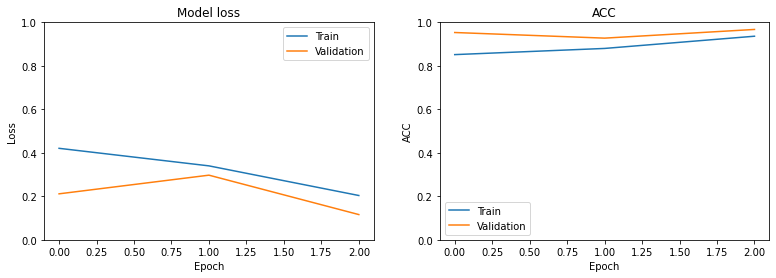

In [35]:
plot_loss(history, title=None)

In [36]:
results = text_model.evaluate(X_text_test_pad, y_test)

print('-'*80)
print(f"test score (ACC): {results[1]:.3f}")
print('-'*80)

419/419 [==============================] - 22s 54ms/step - loss: 0.1164 - accuracy: 0.9679
--------------------------------------------------------------------------------
test score (ACC): 0.968
--------------------------------------------------------------------------------


In [37]:
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

def get_metrics(y_true, X, model):

    y_prob = model.predict(X)
    y_pred = np.where(y_prob > 0.5, 1, 0)

    conf_matrix = confusion_matrix(y_test, y_pred)

    acc = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print('-'*80)
    print(f"acc: {acc*100:.2f}%")
    print(f"recall: {recall*100:.2f}%")
    print(f"precision: {precision*100:.2f}%")
    print(f"f1: {f1*100:.2f}%")
    print('-'*80)

    sns.heatmap(conf_matrix, annot=True, fmt="d");

--------------------------------------------------------------------------------
acc: 96.79%
recall: 96.39%
precision: 97.39%
f1: 96.89%
--------------------------------------------------------------------------------


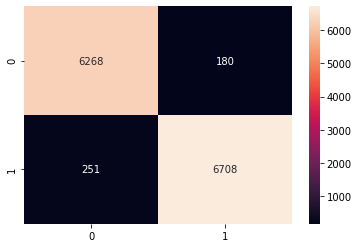

In [38]:
get_metrics(y_test, X_text_test_pad, text_model)

## Prediction

In [46]:
# From Straits Times
X_sample = "The parade and ceremony segment will feature the popular fighter jet aerial \
        displays and the landing of Red Lions parachutists, while the show segment will \
        focus on the Singapore Spirit in a display of the country's identity, resilience and can-do attitude."

In [75]:
fake1 = """
Americans to fund killing babies in abortion that she has been caught trying to add taxpayer financing of abortions to the bill to combat the Coronavirus and provide economic stimulus to the nation as it deals with the COVD-19 outbreak.
Nancy Pelosi has a long history of promoting abortion and her first act after becoming Speaker in 2019 was pushing legislation to use tax money for abortions. So it’s no surprise she is trying to exploit the Coronavirus pandemic to push abortion funding again.
As The Daily Caller reports: House Speaker Nancy Pelosi sought to include a potential way to guarantee federal funding for abortion into the coronavirus economic stimulus plan, according to multiple senior White House officials.
Speaking to the Daily Caller, those officials alleged that while negotiating the stimulus with U.S. Treasury Secretary Steve Mnuchin, Pelosi tried to lobby for “several” provisions that stalled bipartisan commitment to the effort. One was a mandate for up to $1 billion to reimburse laboratory claims, which White House officials say would set a precedent of health spending without protections outlined in the Hyde Amendment.
LifeNews depends on the support of readers like you to combat the pro-abortion media. Please donate now.
“A New mandatory funding stream that does not have Hyde protections would be unprecedented,” one White House official explained. “Under the guise of protecting people, Speaker Pelosi is working to make sure taxpayer dollars are spent covering abortion—which is not only backwards, but goes against historical norms.”
A second White House official referred to the provision as a “slush fund” and yet another questioned “what the Hyde Amendment and abortion have to do with protecting Americans from coronavirus?”
Americans should insist to their members of Congress that we need a clean bill that provides aggressive action to help patients and spur the economy. Killing babies with our tax dollars is not the answer to the coronavirus and the situation should not be exploited for political gain.
"""

true1 = """
Price spikes, however, would cause demand to wither and some expensive avocados might be leftover, and stores might try to ration avocados, he added.
"Exactly what the retail strategy would be in this case, I’m not sure. But we would have vastly fewer avocados," Sumner said.
Just how fast avocados would disappear, if at all, would depend on whether the Trump administration enacts a full or partial border closure. White House economic adviser Larry Kudlow told CNBC he’s looking for ways to keep some commerce flowing.
"We are looking at different options, particularly if you can keep those freight lanes, the truck lanes, open," he said this week.  
Ben Holtz owns Rocky H Ranch, a 70-acre family-run avocado farm in northern San Diego County. He agreed avocados would run out within weeks.
"Mexico is the big player today. California is not. You shut down the border and California can’t produce to meet the demand," Holtz said. "There will be people without their guacamole."
While Mexico’s avocado harvest is year-round, California’s is limited to April through July. Growers in the state have picked only about 3 percent of what’s expected to be a much smaller crop of about 175 million pounds this year, Holtz said. A heat wave last summer reduced the crop size.
California’s avocado harvest has averaged approximately 300 million pounds in recent years, according to data from the California Avocado Commission. By contrast, the U.S. has imported more than 1.5 billion pounds of avocados from Mexico annually. Representatives from the commission did not respond to requests for this article.
Altogether, the U.S. received 43 percent of its fruit and vegetable imports from Mexico in 2016, according to the U.S. Department of Agriculture.
Also affecting this year’s avocado supply, a California avocado company in March recalled shipments to six states last month after fears the fruit might be contaminated with a bacterium that can cause health risks.
Until the early 2000s, California was the nation’s leading supplier of avocados, Holtz said. Mexico gradually overtook the state and now dominates sales in the U.S.
"It’s a very big possibility," Holtz said of avocado shortages. "Three weeks would dry up the Mexican inventory. California alone consumes more avocados than are grown in our state. Cold storage supply chain is basically three weeks or less of inventory. Most of the time it’s seven days."
A spokeswoman for the California Restaurant Association said "we haven’t heard concerns from restaurants, it doesn’t mean they aren’t worried." A national grocers association said it will "continue to closely monitor any developments" at the border, but did not have information about the potential impact on avocados.
"""

In [77]:
fake1

'\nAmericans to fund killing babies in abortion that she has been caught trying to add taxpayer financing of abortions to the bill to combat the Coronavirus and provide economic stimulus to the nation as it deals with the COVD-19 outbreak.\nNancy Pelosi has a long history of promoting abortion and her first act after becoming Speaker in 2019 was pushing legislation to use tax money for abortions. So it’s no surprise she is trying to exploit the Coronavirus pandemic to push abortion funding again.\nAs The Daily Caller reports: House Speaker Nancy Pelosi sought to include a potential way to guarantee federal funding for abortion into the coronavirus economic stimulus plan, according to multiple senior White House officials.\nSpeaking to the Daily Caller, those officials alleged that while negotiating the stimulus with U.S. Treasury Secretary Steve Mnuchin, Pelosi tried to lobby for “several” provisions that stalled bipartisan commitment to the effort. One was a mandate for up to $1 billi

In [85]:
X_sample_clean = clean(fake1)
print(X_sample_clean)

X_sample_token = text_tokenizer.texts_to_sequences(X_sample_clean)
print(X_sample_token)

X_sample_pad = pad_sequences(X_sample_token, maxlen=1000, dtype='float32', padding='post')
print(X_sample_pad.shape)

# y_prob = text_model.predict(X_sample_token)
# y_pred = np.where(y_prob > 0.5, 1, 0)

# print(y_prob, y_pred)

['american', 'fund', 'killing', 'baby', 'abortion', 'caught', 'trying', 'add', 'taxpayer', 'financing', 'abortion', 'bill', 'combat', 'coronavirus', 'provide', 'economic', 'stimulus', 'nation', 'deal', 'covd', 'outbreak', 'nancy', 'pelosi', 'long', 'history', 'promoting', 'abortion', 'first', 'act', 'becoming', 'speaker', 'pushing', 'legislation', 'use', 'tax', 'money', 'abortion', 'surprise', 'trying', 'exploit', 'coronavirus', 'pandemic', 'push', 'abortion', 'funding', 'daily', 'caller', 'report', 'house', 'speaker', 'nancy', 'pelosi', 'sought', 'include', 'potential', 'way', 'guarantee', 'federal', 'funding', 'abortion', 'coronavirus', 'economic', 'stimulus', 'plan', 'according', 'multiple', 'senior', 'white', 'house', 'official', 'speaking', 'daily', 'caller', 'official', 'alleged', 'negotiating', 'stimulus', 'u', 'treasury', 'secretary', 'steve', 'mnuchin', 'pelosi', 'tried', 'lobby', 'several', 'provision', 'stalled', 'bipartisan', 'commitment', 'effort', 'one', 'mandate', 'billi

In [ ]:
sample = "Bonjour, je m'appelle Julien"